In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

%matplotlib inline

In [2]:
train = pd.read_csv('C:/Users/marwi/OneDrive/Desktop/t_direct/kaggle-titanic-master/kaggle-titanic-master/input/train.csv')
test = pd.read_csv('C:/Users/marwi/OneDrive/Desktop/t_direct/kaggle-titanic-master/kaggle-titanic-master/input/test.csv')

In [3]:
titan = [train,test]

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


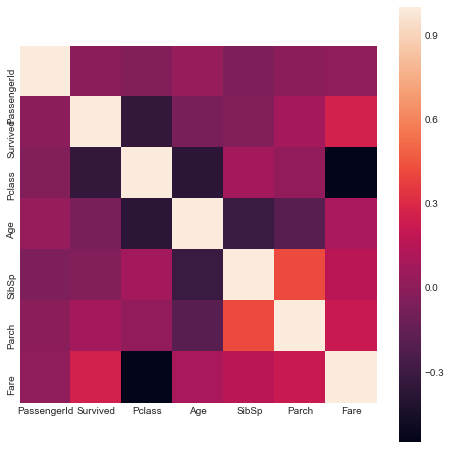

In [7]:
plt.figure(figsize=(8,8))
sns.heatmap(train.corr(), square=True)
plt.show()

There are many low correlations but we hope to find more by creating features that convert the objects to integers and mapping the values. We will begin looking at the columns with missing values before moving on to more features. For example, at index 0 in the 'test.head()' above, 'Kelly, Mr. James' is 34.5 years old and his Fare was 7.8292, which is strange but maybe we can remove some ambiguity with a binning technique. Fare has the fewest missing values so we will begin there.

In [8]:
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

In [9]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [10]:
#Since Embarked only has two missing values, we will just fill it with 'S'.
train['Embarked'] = train['Embarked'].fillna('S')

In [11]:
#Age is not missing a significant amount of data so we will fill it using the average.
train['Age'] = train['Age'].fillna(train['Age'].median())
test['Age'] = test['Age'].fillna(test['Age'].median())

Cabin has the largest amount of missing values so first I will convert it to an integer by isolating the letters that represents the cabin areas and using a groupby method with passenger class because it represents where the cabins are located for each class of passenger.

In [12]:
train['Cabin'].value_counts()

G6             4
C23 C25 C27    4
B96 B98        4
D              3
F33            3
E101           3
C22 C26        3
F2             3
D33            2
D36            2
B77            2
B5             2
E8             2
B28            2
B35            2
D35            2
C92            2
C68            2
C83            2
B58 B60        2
E44            2
C126           2
B20            2
C124           2
E24            2
E25            2
F G73          2
B51 B53 B55    2
C78            2
D26            2
              ..
D7             1
B4             1
A10            1
B73            1
D11            1
E12            1
C45            1
A23            1
E40            1
C148           1
B80            1
C99            1
B41            1
D49            1
C128           1
D37            1
C85            1
C103           1
C62 C64        1
C111           1
B71            1
B86            1
C106           1
B30            1
C90            1
A32            1
E31            1
E34           

In [13]:
for cab in titan:
    cab['Cabin'] = cab['Cabin'].str[:1]
    
train['Cabin'].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

In [14]:
#Because passenger class has only 3 values, I will map it on a similar range.
cab_map = {'A':0, 'B':0.5, 'C':1.0, 'D':1.5, 'E':2.0, 'F':2.5, 'G':3.0, 'T':3.5}
for cab in titan:
    cab['Cabin'] = cab['Cabin'].map(cab_map)

In [15]:
#Because the passenger class is a factor of cabin location, 
#we use groupby to assign cabins based on the average cabins per passenger class.
train['Cabin'].fillna(train.groupby('Pclass')['Cabin'].transform('median'), inplace=True)
test['Cabin'].fillna(test.groupby('Pclass')['Cabin'].transform('median'), inplace=True)

Now that there are no null values, I will begin to map other features to convert them to integers. Sibsp represents sibling and spouse while Parch represents parent and child, which seems unneccesary so I will combine both to create a 'Families' feature. 

In [16]:
#Even though Sex is labeled as an integer it appears to be a string.
gender = {'male':0, 'female':1}
for g in titan:
    g['Sex'] = g['Sex'].map(gender)

In [17]:
train['Families'] = train['SibSp'] + train['Parch']
test['Families'] = test['SibSp'] + test['Parch']

In [18]:
train['Families'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Families, dtype: int64

In [19]:
#Because of the limited range of values I will map it according to the previous range.
fam_map = {1:0, 2:0.5, 3:1.0, 4:1.5, 5:2.0, 6:2.5, 7:3.0, 10:3.5}
for fam in titan:
    fam['Families'] = fam['Families'].map(fam_map)

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null float64
Embarked       891 non-null object
Families       354 non-null float64
dtypes: float64(4), int64(6), object(3)
memory usage: 90.6+ KB


Now there are alot of missing values for the Families feature, so I will pull the titles from the Name column because families normally include people with titles such as Mr., Mrs., or otherwise for unmarried and single parents. Then use the groupby method to assign values to fill the features according to averages.  

In [21]:
for call in titan:
    call['Title'] = call['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Lady          1
Don           1
Sir           1
Mme           1
Ms            1
Jonkheer      1
Countess      1
Capt          1
Name: Title, dtype: int64

In [22]:
titles = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Dr': 3, 'Rev': 3, 
          'Col': 3, 'Major': 3, 'Mlle': 3, 'Countess': 3, 'Ms': 3, 'Lady': 3,
          'Jonkheer': 3, 'Don': 3, 'Dona': 3, 'Mme': 3, 'Capt': 3, 'Sir': 3}
for call in titan:
    call['Title'] = call['Title'].map(titles)

In [23]:
train['Families'].fillna(train.groupby('Title')['Families'].transform('median'), inplace=True)
test['Families'].fillna(test.groupby('Title')['Families'].transform('median'), inplace=True)

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null float64
Embarked       891 non-null object
Families       891 non-null float64
Title          891 non-null int64
dtypes: float64(4), int64(7), object(3)
memory usage: 97.5+ KB


Next, I will convert Embarked to numerical mapping. I will assign numbers for Sex because even though it is an integer column, within the data it seems to be a string. Then I will map Age and Fare to a similar range we used for the previous variable maps. And afterwards drop a few columns that we created new features from. This includes dropping the PassengerId and Ticket columns because there are too many unique variables with little relation to the passengers personally.

In [25]:
bark_map = {'S':0, 'C':1, 'Q':2}
for bark in titan:
    bark['Embarked'] = bark['Embarked'].map(bark_map)

In [26]:
for ag in titan:
    ag.loc[ag['Age']<=21,'Age'] = 0,
    ag.loc[(ag['Age']>21) & (ag['Age']<=30),'Age'] = 1,
    ag.loc[(ag['Age']>30) & (ag['Age']<=40), 'Age'] = 2,
    ag.loc[(ag['Age']>40) & (ag['Age']<=50), 'Age'] = 3,
    ag.loc[ag['Age']>50, 'Age'] = 3.5    

In [27]:
for f in titan:
    f.loc[f['Fare']<=20,'Fare'] = 0,
    f.loc[(f['Fare']>20) & (f['Fare']<=50), 'Fare'] = 1,
    f.loc[(f['Fare']>50) & (f['Fare']<=80), 'Fare'] = 2,
    f.loc[f['Fare']>80, 'Fare'] = 3

In [28]:
train = train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket'], axis=1)
test = test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket'], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int64
Age         891 non-null float64
Fare        891 non-null float64
Cabin       891 non-null float64
Embarked    891 non-null int64
Families    891 non-null float64
Title       891 non-null int64
dtypes: float64(4), int64(5)
memory usage: 62.7 KB


In [29]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Families,Title
0,0,3,0,1.0,0.0,2.5,0,0.0,0
1,1,1,1,2.0,2.0,1.0,1,0.0,2
2,1,3,1,1.0,0.0,2.5,0,0.5,1
3,1,1,1,2.0,2.0,1.0,0,0.0,2
4,0,3,0,2.0,0.0,2.5,0,0.0,0


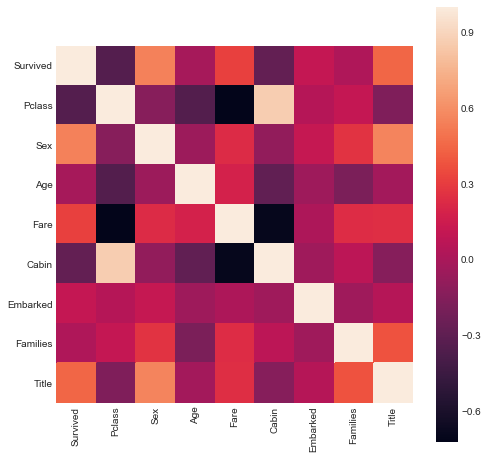

In [30]:
plt.figure(figsize=(8,8))
sns.heatmap(train.corr(), square=True)
plt.show()

In [31]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [32]:
X_clf = train.iloc[:,1:9]
y_clf = train.iloc[:,0]

In [33]:
da_best = SelectKBest(score_func=chi2, k=5).fit_transform(X_clf, y_clf)
print(da_best[:5])

[[3.  0.  0.  2.5 0. ]
 [1.  1.  2.  1.  2. ]
 [3.  1.  0.  2.5 1. ]
 [1.  1.  2.  1.  2. ]
 [3.  0.  0.  2.5 0. ]]


In [34]:
print(X_clf.head())

   Pclass  Sex  Age  Fare  Cabin  Embarked  Families  Title
0       3    0  1.0   0.0    2.5         0       0.0      0
1       1    1  2.0   2.0    1.0         1       0.0      2
2       3    1  1.0   0.0    2.5         0       0.5      1
3       1    1  2.0   2.0    1.0         0       0.0      2
4       3    0  2.0   0.0    2.5         0       0.0      0


Our 5 best features based on the rate of survival are Pclass, Sex, Fare, Cabin, and Title. Which makes sense because in accordance to typical survival priorities,(see 'Titanic' movie), women and children are first but ofcourse fathers are likely to be selected too. Also, in regards to fare which relates to how much a passenger paid to be in first class, we noticed in the film that first class passengers are placed nearest to the life boats which attributes to their survival rate.